# Comprehensive Model Evaluation

Evaluate all trained LSTM models across all decision points with full classification reports, feature importance analysis, and CSV exports.


In [ ]:
import sys
import os
import warnings

sys.path.insert(0, os.path.dirname(os.getcwd()))

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from storage import ModelPersistence
from evaluation import ModelEvaluator, FeatureImportanceAnalyzer
from sklearn.metrics import classification_report

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")


d:\Repos\process-simulation-engine\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 1. Configuration


In [ ]:
MODELS_DIR = os.path.join(os.getcwd(), "..", "models_lstm_new")
DATA_PATH = os.path.join(os.getcwd(), "..", "data", "processed", "dp_split_datasets_full_simple.joblib")
OUTPUT_DIR = os.path.join(os.getcwd(), "..", "data", "processed")

N_IMPORTANCE_REPEATS = 3  # Number of permutation repeats for feature importance


## 2. Load Data and List Available Models


In [ ]:
splits = joblib.load(DATA_PATH)

available_models = sorted(
    [d.replace("_", " ") for d in os.listdir(MODELS_DIR) if os.path.isdir(os.path.join(MODELS_DIR, d))],
    key=lambda x: int(x.split()[1])
)

print(f"Available models: {len(available_models)}")
print(f"Decision points in data: {len(splits)}")
print(", ".join(available_models))


Available models: 43
DP 1, DP 3, DP 4, DP 5, DP 7, DP 8, DP 9, DP 10, DP 11, DP 12, DP 13, DP 14, DP 15, DP 16, DP 17, DP 19, DP 20, DP 21, DP 22, DP 23, DP 25, DP 26, DP 27, DP 28, DP 29, DP 30, DP 31, DP 32, DP 33, DP 34, DP 35, DP 36, DP 37, DP 39, DP 40, DP 41, DP 42, DP 43, DP 44, DP 46, DP 47, DP 48, DP 49


## 3. Evaluate All Decision Points

Run full evaluation (classification report + feature importance) for each decision point.


In [ ]:
summary_results = []
per_class_results = []
importance_results = []

for i, dp in enumerate(available_models):
    dp_path = os.path.join(MODELS_DIR, dp.replace(" ", "_"))
    df_holdout = splits.get(dp, {}).get("holdout", pd.DataFrame())
    
    if df_holdout.empty:
        print(f"[{i+1}/{len(available_models)}] {dp}: No holdout data, skipping")
        continue
    
    print(f"[{i+1}/{len(available_models)}] {dp}...", end=" ")
    
    bundle = ModelPersistence.load(dp_path)
    evaluator = ModelEvaluator(bundle)
    X_test, y_test = evaluator.prepare_holdout(df_holdout)
    
    # Get predictions
    y_pred = np.argmax(bundle["model"].predict(X_test, verbose=0), axis=1)
    
    # Full classification report
    report = classification_report(
        y_test, y_pred,
        target_names=bundle["label_encoder"].classes_,
        output_dict=True,
        zero_division=0
    )
    
    # Baseline comparison
    baseline = evaluator.baseline_report(y_test)
    f1_lstm = report["weighted avg"]["f1-score"]
    f1_base = baseline["weighted avg"]["f1-score"]
    improvement = (f1_lstm - f1_base) / f1_base * 100 if f1_base > 0 else 0
    
    # Summary row
    summary_results.append({
        "decision_point": dp,
        "n_samples": len(df_holdout),
        "n_classes": len(bundle["label_encoder"].classes_),
        "accuracy": report["accuracy"],
        "f1_weighted": f1_lstm,
        "f1_macro": report["macro avg"]["f1-score"],
        "precision_weighted": report["weighted avg"]["precision"],
        "recall_weighted": report["weighted avg"]["recall"],
        "f1_baseline": f1_base,
        "improvement_pct": improvement
    })
    
    # Per-class metrics
    for label in bundle["label_encoder"].classes_:
        if label in report:
            per_class_results.append({
                "decision_point": dp,
                "class": label,
                "precision": report[label]["precision"],
                "recall": report[label]["recall"],
                "f1": report[label]["f1-score"],
                "support": report[label]["support"]
            })
    
    # Feature importance
    analyzer = FeatureImportanceAnalyzer(bundle["model"])
    importances, feature_names, baseline_acc = analyzer.all_features_importance(
        X_test, y_test,
        context_feature_names=bundle["context_keys"],
        n_repeats=N_IMPORTANCE_REPEATS
    )
    
    imp_row = {"decision_point": dp, "baseline_accuracy": baseline_acc}
    for name, imp in zip(feature_names, importances):
        imp_row[name] = imp
    importance_results.append(imp_row)
    
    print(f"F1={f1_lstm:.3f}, Improvement={improvement:.1f}%")

print(f"\nCompleted evaluation for {len(summary_results)} decision points")


Loaded model for DP 1
  Activities: 2
  Resources: 112
  Classes: ['A_Concept', 'A_Submitted', 'W_Complete application']
  Max sequence length: 1


In [ ]:
df_summary = pd.DataFrame(summary_results)
df_per_class = pd.DataFrame(per_class_results)
df_importance = pd.DataFrame(importance_results)

df_summary = df_summary.sort_values("decision_point", key=lambda x: x.str.extract(r"(\d+)")[0].astype(int))
df_summary = df_summary.reset_index(drop=True)

print("Summary DataFrame shape:", df_summary.shape)
print("Per-class DataFrame shape:", df_per_class.shape)
print("Feature importance DataFrame shape:", df_importance.shape)


Holdout set: 3151 samples
Label distribution:
label
A_Submitted               2042
W_Complete application     770
A_Concept                  339
Name: count, dtype: int64


## 4. Summary Statistics


In [ ]:
print("=== Overall Performance ===\n")
print(f"Total decision points evaluated: {len(df_summary)}")
print(f"Total samples across all DPs: {df_summary['n_samples'].sum():,}")
print(f"\nMetric Averages:")
print(f"  Accuracy:         {df_summary['accuracy'].mean():.3f} (std: {df_summary['accuracy'].std():.3f})")
print(f"  F1 Weighted:      {df_summary['f1_weighted'].mean():.3f} (std: {df_summary['f1_weighted'].std():.3f})")
print(f"  F1 Macro:         {df_summary['f1_macro'].mean():.3f} (std: {df_summary['f1_macro'].std():.3f})")
print(f"  Baseline F1:      {df_summary['f1_baseline'].mean():.3f} (std: {df_summary['f1_baseline'].std():.3f})")
print(f"  Improvement:      {df_summary['improvement_pct'].mean():.1f}% (std: {df_summary['improvement_pct'].std():.1f}%)")

print("\n=== Top 10 Best Performing Decision Points ===")
df_summary.nlargest(10, "f1_weighted")[["decision_point", "n_samples", "n_classes", "f1_weighted", "improvement_pct"]]


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
                        precision    recall  f1-score   support

             A_Concept       1.00      1.00      1.00       339
           A_Submitted       1.00      1.00      1.00      2042
W_Complete application       1.00      1.00      1.00       770

              accuracy                           1.00      3151
             macro avg       1.00      1.00      1.00      3151
          weighted avg       1.00      1.00      1.00      3151


Per-Class Accuracy:
A_Concept: 99.71%
A_Submitted: 100.00%
W_Complete application: 100.00%


## 5. Visualizations


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# F1 Score Comparison (LSTM vs Baseline)
ax1 = axes[0, 0]
x = range(len(df_summary))
width = 0.35
ax1.bar([i - width/2 for i in x], df_summary["f1_weighted"], width, label="LSTM", color="#2ecc71")
ax1.bar([i + width/2 for i in x], df_summary["f1_baseline"], width, label="Baseline", color="#e74c3c", alpha=0.7)
ax1.set_xlabel("Decision Point")
ax1.set_ylabel("F1 Score (Weighted)")
ax1.set_title("F1 Score: LSTM vs Random Baseline")
ax1.set_xticks(x)
ax1.set_xticklabels([dp.replace("DP ", "") for dp in df_summary["decision_point"]], rotation=45, ha="right")
ax1.legend()
ax1.set_ylim(0, 1.1)

# Improvement Distribution
ax2 = axes[0, 1]
ax2.hist(df_summary["improvement_pct"], bins=20, color="#3498db", edgecolor="white")
ax2.axvline(df_summary["improvement_pct"].mean(), color="#e74c3c", linestyle="--", label=f"Mean: {df_summary['improvement_pct'].mean():.1f}%")
ax2.set_xlabel("Improvement over Baseline (%)")
ax2.set_ylabel("Count")
ax2.set_title("Distribution of Improvement over Baseline")
ax2.legend()

# Accuracy by Number of Classes
ax3 = axes[1, 0]
scatter = ax3.scatter(df_summary["n_classes"], df_summary["f1_weighted"], 
                       c=df_summary["n_samples"], cmap="viridis", s=80, alpha=0.7)
ax3.set_xlabel("Number of Classes")
ax3.set_ylabel("F1 Score (Weighted)")
ax3.set_title("F1 Score vs Number of Classes (color = sample size)")
plt.colorbar(scatter, ax=ax3, label="Sample Size")

# Sample Size vs Performance
ax4 = axes[1, 1]
ax4.scatter(df_summary["n_samples"], df_summary["f1_weighted"], c="#9b59b6", s=80, alpha=0.7)
ax4.set_xlabel("Number of Samples")
ax4.set_ylabel("F1 Score (Weighted)")
ax4.set_title("F1 Score vs Sample Size")
ax4.set_xscale("log")

plt.tight_layout()
plt.show()



=== Comparison for DP 1 ===
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
Weighted F1 (LSTM):     1.000
Weighted F1 (Baseline): 0.483
Relative Improvement:   106.76%


## 6. Feature Importance Heatmap


In [ ]:
feature_cols = [c for c in df_importance.columns if c not in ["decision_point", "baseline_accuracy"]]
importance_matrix = df_importance.set_index("decision_point")[feature_cols]

# Sort by DP number
importance_matrix = importance_matrix.loc[
    sorted(importance_matrix.index, key=lambda x: int(x.split()[1]))
]

plt.figure(figsize=(12, max(8, len(importance_matrix) * 0.3)))
sns.heatmap(
    importance_matrix,
    cmap="RdYlGn",
    center=0,
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "Importance (Δ accuracy)"},
    linewidths=0.5
)
plt.title("Feature Importance Across All Decision Points")
plt.xlabel("Feature")
plt.ylabel("Decision Point")
plt.tight_layout()
plt.show()

print("\n=== Average Feature Importance ===")
avg_importance = importance_matrix.mean().sort_values(ascending=False)
for feat, imp in avg_importance.items():
    print(f"  {feat}: {imp:.4f}")



Baseline accuracy: 1.000

Feature importances:
  resource_sequence: 0.4496
  case:ApplicationType: 0.1201
  case:LoanGoal: 0.0000
  activity_sequence: 0.0000
  duration_sequence: 0.0000
  case:RequestedAmount: -0.0002


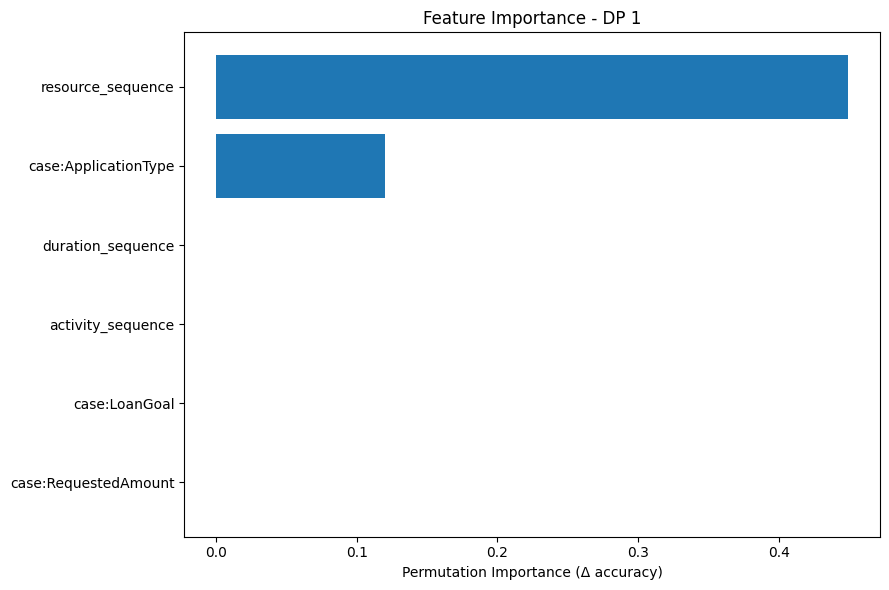

In [ ]:
# Average importance bar chart
plt.figure(figsize=(10, 5))
avg_importance = importance_matrix.mean().sort_values(ascending=True)
colors = ["#2ecc71" if v > 0 else "#e74c3c" for v in avg_importance]
plt.barh(avg_importance.index, avg_importance.values, color=colors)
plt.xlabel("Average Importance (Δ accuracy)")
plt.title("Average Feature Importance Across All Decision Points")
plt.axvline(0, color="black", linewidth=0.5)
plt.tight_layout()
plt.show()


## 7. Export Results to CSV


In [ ]:
summary_path = os.path.join(OUTPUT_DIR, "evaluation_summary.csv")
per_class_path = os.path.join(OUTPUT_DIR, "evaluation_per_class.csv")
importance_path = os.path.join(OUTPUT_DIR, "evaluation_feature_importance.csv")

df_summary.to_csv(summary_path, index=False)
df_per_class.to_csv(per_class_path, index=False)
df_importance.to_csv(importance_path, index=False)

print("Exported results to:")
print(f"  {summary_path}")
print(f"  {per_class_path}")
print(f"  {importance_path}")


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
187/560 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

## 8. Full Results Tables


In [ ]:
print("=== Summary Table (all decision points) ===")
df_summary.style.format({
    "accuracy": "{:.3f}",
    "f1_weighted": "{:.3f}",
    "f1_macro": "{:.3f}",
    "precision_weighted": "{:.3f}",
    "recall_weighted": "{:.3f}",
    "f1_baseline": "{:.3f}",
    "improvement_pct": "{:.1f}%"
})


In [ ]:
print("=== Feature Importance Table ===")
df_importance.set_index("decision_point").style.format("{:.4f}")
